## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
from estimator_selection_helper import  EstimatorSelectionHelper
sns.set()
# to ignore warnings when using Grid Search
filterwarnings(action='ignore',
               message=".*Setting penalty='none' will ignore the C and l1_ratio parameters.*")

In [2]:
def get_coefs_of_regression(regression, df):
    return pd.Series(np.ravel(regression.coef_), index=df.columns.values)

## Data cleaning

In [3]:

df_all = pd.read_csv('data/train.csv')
df_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# print count of na values.
column_wise_nans = df_all.isna().sum(0)
percent_of_nans = column_wise_nans / df_all.shape[0] * 100
print(f'Percent of nans in columns: \n\n{percent_of_nans}')

Percent of nans in columns: 

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [5]:
# dropping useless labels
df_all.drop(labels=['Ticket', 'Cabin', 'Name', 'PassengerId'],axis=1, inplace=True)

# working with na
df_all.dropna(inplace=True)
# using one hot encoding for categorical data
df_all = pd.get_dummies(df_all, columns=['Sex', 'Embarked'])

df_all.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


## Finding best model

In [6]:
df_X = df_all.drop(labels='Survived', axis=1)
X = df_X.to_numpy()
y = df_all['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


In [7]:
test_pipeline = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression())])
pipeline_parameters = [
    {
        'estimator__fit_intercept': [True, False],
        'estimator__penalty': ['l2', 'none'],
        'estimator__C': [0.001, 0.01, 0.04, 0.2, 0.4, 0.8, 1],
        'estimator__max_iter': [1000],
        # 'data_transformer': [MinMaxScaler(), 'passthrough']
    }
]
grid = GridSearchCV(test_pipeline, pipeline_parameters, cv=5)
grid.fit(X_train, y_train)
print(f'best parameter: {grid.best_params_}')
grid.score(X_test, y_test)

best parameter: {'estimator__C': 0.001, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__penalty': 'none'}


0.8601398601398601

In [8]:
pd.Series(np.ravel(grid.best_estimator_['estimator'].coef_), index=df_X.columns.values)

Pclass       -2.248454
Age          -3.609069
SibSp        -1.867101
Parch        -0.395198
Fare          1.190019
Sex_female    1.967395
Sex_male     -0.454811
Embarked_C    0.841519
Embarked_Q    0.265855
Embarked_S    0.405210
dtype: float64

Our model has high bias

In [9]:
from sklearn.model_selection import learning_curve
def plot_learning_curves(model, X, y):
    N, train_lc, val_lc = learning_curve(model,
                                         X, y, cv=3,
                                         train_sizes=np.linspace(0.1, 1, 20))
    plt.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    plt.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    plt.legend()

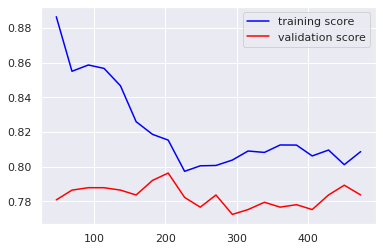

In [10]:
plot_learning_curves(grid.best_estimator_, X, y)

## Fooling around with SVC

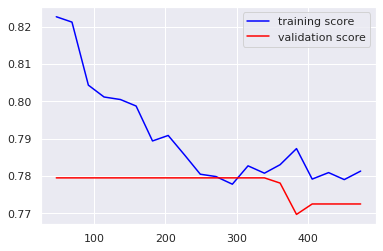

In [11]:
from sklearn.svm import SVC
pipe = make_pipeline(MinMaxScaler(),
                     SVC(kernel='linear', C=1, max_iter=4000))
plot_learning_curves(pipe, X, y)

In [12]:
pipe = make_pipeline(MinMaxScaler(),
                     SVC(kernel='linear', C=1, max_iter=1e6))
m = pipe.fit(X, y)

In [13]:
m.score(X, y)

0.7794943820224719

## Trying add/delete new features to increase performance of logistic regression

In [14]:
def display_estimator_result(X_train, y_train, C=0.01):
    model = Pipeline([('data_transformer', MinMaxScaler()),
                      ('estimator', LogisticRegression(C=C, fit_intercept=False))])
    cv_result = cross_validate(model, X_train, y_train, cv=5)
    plot_learning_curves(model, X_train, y_train)
    print(cv_result['test_score'])
    return model.fit(X_train, y_train)

### finding coefs of regression after training on all data

[0.77622378 0.82517483 0.8028169  0.73239437 0.80985915]


Pclass       -0.347924
Age          -0.048910
SibSp        -0.021020
Parch         0.019922
Fare          0.062056
Sex_female    0.493629
Sex_male     -0.484002
Embarked_C    0.146251
Embarked_Q   -0.032234
Embarked_S   -0.104390
dtype: float64

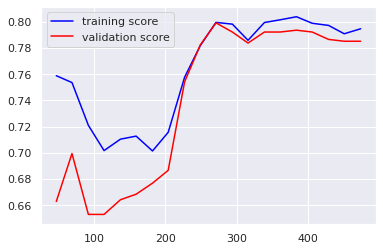

In [15]:
get_coefs_of_regression(display_estimator_result(X, y)['estimator'], df_X)

### what will be if we only use "Sex" as feature?

[0.78321678 0.81818182 0.77464789 0.73239437 0.78873239]


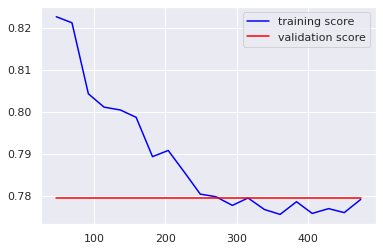

In [16]:
test_df = df_all.copy()
# # 'Parch', 'SibSp', 'Embarked_C', 'Embarked_Q', 'Embarked_S'
# test_df.drop(labels=['Survived', 'Pclass'], axis=1, inplace=True)
test_df = df_all[['Sex_female', 'Sex_male']]
test_model = display_estimator_result(test_df.to_numpy(), y, C=1)

Training result stays the same!!!

### Remove only sex parameter

[0.61538462 0.70629371 0.75352113 0.76760563 0.69014085]


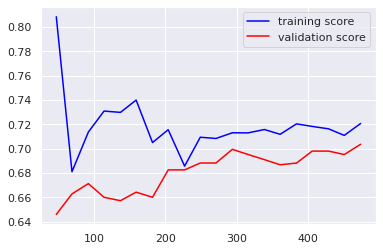

In [17]:
test_df = df_X.copy()
test_df.drop(labels=['Sex_female', 'Sex_male'], axis=1, inplace=True)
test_model = display_estimator_result(test_df.to_numpy(), y, C=1e6)

[0.59440559 0.68531469 0.61267606 0.67605634 0.63380282]


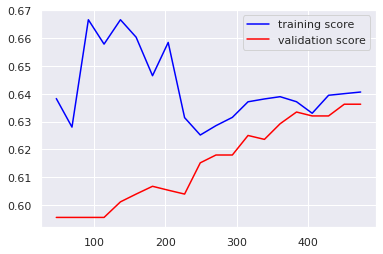

In [18]:
test_df = df_X.copy()
test_df.drop(labels=['Sex_female', 'Sex_male'], axis=1, inplace=True)
test_model = display_estimator_result(test_df.to_numpy(), y, C=0.01)

## Playing with penalty

In [68]:
def playing_with_penalty(C=1, penalty='l2'):
    model = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression(penalty=penalty, C=C))])
    plot_learning_curves(model, X, y)
    model.fit(X, y)
    return get_coefs_of_regression(model['estimator'], df_X)

Pclass       -2.398508
Age          -3.449790
SibSp        -1.816012
Parch        -0.361639
Fare          0.733461
Sex_female    2.053544
Sex_male     -0.584941
Embarked_C    0.897811
Embarked_Q    0.074209
Embarked_S    0.496582
dtype: float64

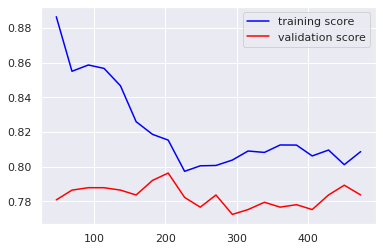

In [70]:
# small penalty
playing_with_penalty(C=1e6)

Pclass       -2.393811
Age          -3.430685
SibSp        -1.803842
Parch        -0.360502
Fare          0.725396
Sex_female    1.320790
Sex_male     -1.315619
Embarked_C    0.410035
Embarked_Q   -0.412723
Embarked_S    0.007858
dtype: float64

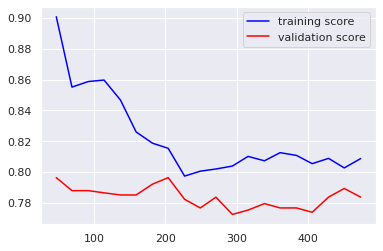

In [74]:
playing_with_penalty(C=1e2)

Pclass       -2.063324
Age          -2.259569
SibSp        -1.117715
Parch        -0.263937
Fare          0.423856
Sex_female    1.250759
Sex_male     -1.251334
Embarked_C    0.401858
Embarked_Q   -0.352032
Embarked_S   -0.050401
dtype: float64

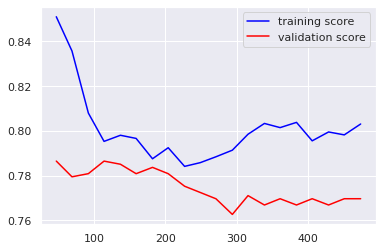

In [75]:
# bigger penalty
playing_with_penalty(C=1)

Pclass       -1.525622
Age          -0.947809
SibSp        -0.451387
Parch        -0.102234
Fare          0.255880
Sex_female    1.129621
Sex_male     -1.129637
Embarked_C    0.364831
Embarked_Q   -0.242163
Embarked_S   -0.122685
dtype: float64

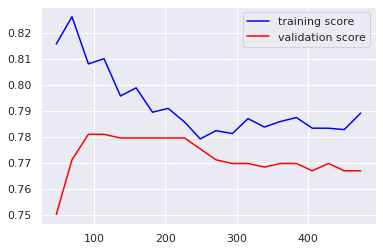

In [80]:
playing_with_penalty(C=0.2)

Pclass       -0.352486
Age          -0.052472
SibSp        -0.021975
Parch         0.019217
Fare          0.061180
Sex_female    0.489238
Sex_male     -0.489239
Embarked_C    0.143369
Embarked_Q   -0.032840
Embarked_S   -0.110530
dtype: float64

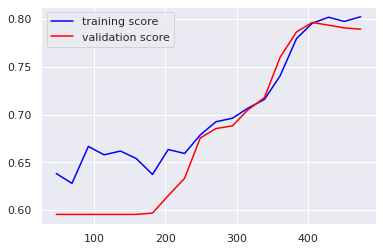

In [77]:
# really strong penalty
playing_with_penalty(C=0.01)

## Let's combine two estimators

In this section I want to implement estimator that will combine results of prediction based only on "Sex" parameter and on prediction based on other parameters

In [19]:
def train_estimator_via_grid(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    pipeline = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression())])
    grid_parameters = [
        {
            'estimator__fit_intercept': [True, False],
            'estimator__C': [0.001, 0.01, 0.4, 1, 100],
        }]
    grid = GridSearchCV(pipeline, grid_parameters, cv=5)
    grid.fit(X_train, y_train)
    plot_learning_curves(grid.best_estimator_, X, y)
    print(f'score: {grid.score(X_test, y_test)}')
    print(f'best params: {grid.best_params_}')
    return grid.best_estimator_, X_train, y_train

In [20]:
def drop_df_columns(df, columns):
    return  df.drop(labels=columns, axis=1, inplace=False).to_numpy()

score: 0.7342657342657343
best params: {'estimator__C': 1, 'estimator__fit_intercept': True}


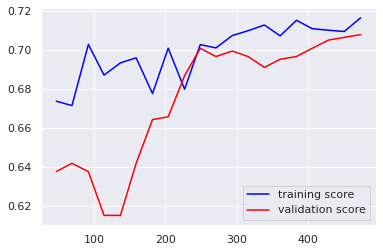

In [21]:
model_without_sex, X_train_without_sex, y_train_without_sex = train_estimator_via_grid(drop_df_columns(df_X, ['Sex_female', 'Sex_male']), y)

score: 0.7902097902097902
best params: {'estimator__C': 0.001, 'estimator__fit_intercept': False}


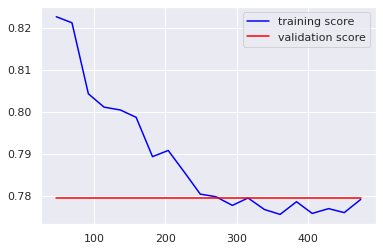

In [22]:
model_with_sex, X_train_with_sex, y_train_with_sex = train_estimator_via_grid(df_X[['Sex_male', 'Sex_female']], y)

### Хочу понять совершают ли пресказатели ошибки систематически или только когда не уверенны в ответе?

In [145]:
df = pd.DataFrame(model_without_sex.predict_proba(X_train_without_sex))
df['y'] = y_train_without_sex
df

,0,1,y
0,0.576765,0.423235,0
1,0.773090,0.226910,0
2,0.855655,0.144345,1
3,0.483851,0.516149,0
4,0.251701,0.748299,1
...,...,...,...
564,0.776322,0.223678,0
565,0.564688,0.435312,1
566,0.806562,0.193438,0
567,0.568585,0.431415,1


In [147]:
prob_without_sex = model_without_sex.predict_proba(X_train_without_sex)
prob_with_sex = model_with_sex.predict_proba(X_train_with_sex)

In [170]:
pred_without_sex = np.argmax(prob_without_sex, axis=1)
max_prob_without_sex = np.max(prob_without_sex, axis=1)

pred_with_sex = np.argmax(prob_with_sex, axis=1)
max_prob_with_sex = np.max(prob_with_sex, axis=1)


In [171]:
max_prob_with_sex

array([0.5109403 , 0.5109403 , 0.5109403 , 0.52552375, 0.52552375,
       0.5109403 , 0.52552375, 0.52552375, 0.5109403 , 0.5109403 ,
       0.52552375, 0.5109403 , 0.5109403 , 0.5109403 , 0.5109403 ,
       0.52552375, 0.52552375, 0.52552375, 0.5109403 , 0.52552375,
       0.5109403 , 0.5109403 , 0.52552375, 0.5109403 , 0.52552375,
       0.5109403 , 0.52552375, 0.5109403 , 0.5109403 , 0.52552375,
       0.52552375, 0.5109403 , 0.5109403 , 0.52552375, 0.52552375,
       0.52552375, 0.52552375, 0.52552375, 0.5109403 , 0.52552375,
       0.52552375, 0.5109403 , 0.52552375, 0.52552375, 0.52552375,
       0.5109403 , 0.52552375, 0.52552375, 0.5109403 , 0.52552375,
       0.52552375, 0.52552375, 0.52552375, 0.52552375, 0.5109403 ,
       0.52552375, 0.5109403 , 0.52552375, 0.52552375, 0.5109403 ,
       0.52552375, 0.5109403 , 0.5109403 , 0.52552375, 0.52552375,
       0.52552375, 0.5109403 , 0.52552375, 0.52552375, 0.52552375,
       0.52552375, 0.52552375, 0.5109403 , 0.52552375, 0.52552

In [172]:
max_prob_without_sex

array([0.57676474, 0.77309036, 0.85565485, 0.51614888, 0.74829899,
       0.76160602, 0.86865161, 0.68966286, 0.57121114, 0.57183151,
       0.74030842, 0.83731322, 0.53810596, 0.54367323, 0.71544905,
       0.84192102, 0.84781405, 0.7534096 , 0.71816295, 0.53755966,
       0.66272636, 0.5174355 , 0.56563953, 0.62572365, 0.58105733,
       0.53782688, 0.57092452, 0.63629945, 0.75326666, 0.73153707,
       0.74113144, 0.64128771, 0.70702311, 0.82950704, 0.77075479,
       0.58521455, 0.56521196, 0.6177116 , 0.69675285, 0.5042735 ,
       0.71996739, 0.73661487, 0.58060997, 0.74410933, 0.70255137,
       0.71332086, 0.6929153 , 0.71770676, 0.54251066, 0.67827636,
       0.77389566, 0.6552666 , 0.80377963, 0.72511663, 0.76567885,
       0.58184731, 0.77192763, 0.72699632, 0.64674513, 0.76525688,
       0.61196175, 0.74919566, 0.54222492, 0.58318969, 0.65016489,
       0.75030187, 0.62063978, 0.7528124 , 0.64157661, 0.72894641,
       0.63419715, 0.62100852, 0.73153707, 0.66890173, 0.74053

In [148]:
pred_without_sex = np.argmax(prob_without_sex, axis=1)
pred_with_sex = np.argmax(prob_with_sex, axis=1)
res = np.zeros_like(y)
for i in range(pred_without_sex.size):
    label_with_sex = pred_with_sex[i]
    label_without_sex = pred_without_sex[i]
    if label_without_sex == label_with_sex:
        res[i] = label_with_sex
        continue

    if prob_without_sex[i, label_without_sex] > pred_with_sex[i, label_with_sex]:
        res[i] = label_without_sex
    else:
        res[i] = label_with_sex

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

### Covariance matrix

In [12]:
covariance = df_all.cov()

covariance.style.background_gradient(cmap='coolwarm').format(precision=2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,0.24,-0.15,-0.59,-0.01,0.04,6.92,0.13,-0.13,0.04,-0.00,-0.03
Pclass,-0.15,0.70,-4.44,0.05,0.02,-24.49,-0.06,0.06,-0.09,0.02,0.07
Age,-0.59,-4.44,210.05,-4.15,-2.33,71.46,-0.69,0.69,0.21,-0.06,-0.15
SibSp,-0.01,0.05,-4.15,0.87,0.30,6.89,0.05,-0.05,-0.02,0.01,0.01
Parch,0.04,0.02,-2.33,0.30,0.73,9.34,0.10,-0.10,-0.00,-0.00,0.00
Fare,6.92,-24.49,71.46,6.89,9.34,2802.50,4.65,-4.65,6.17,-0.64,-5.53
Sex_female,0.13,-0.06,-0.69,0.05,0.10,4.65,0.23,-0.23,0.02,0.00,-0.02
Sex_male,-0.13,0.06,0.69,-0.05,-0.10,-4.65,-0.23,0.23,-0.02,-0.00,0.02
Embarked_C,0.04,-0.09,0.21,-0.02,-0.00,6.17,0.02,-0.02,0.15,-0.01,-0.14
Embarked_Q,-0.00,0.02,-0.06,0.01,-0.00,-0.64,0.00,-0.00,-0.01,0.04,-0.03


## Trying to visualize different features

/home/vsevolod/anaconda3/envs/main/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<AxesSubplot:title={'center':'survived_perc'}>,
       <AxesSubplot:title={'center':'perc_of_all'}>], dtype=object)

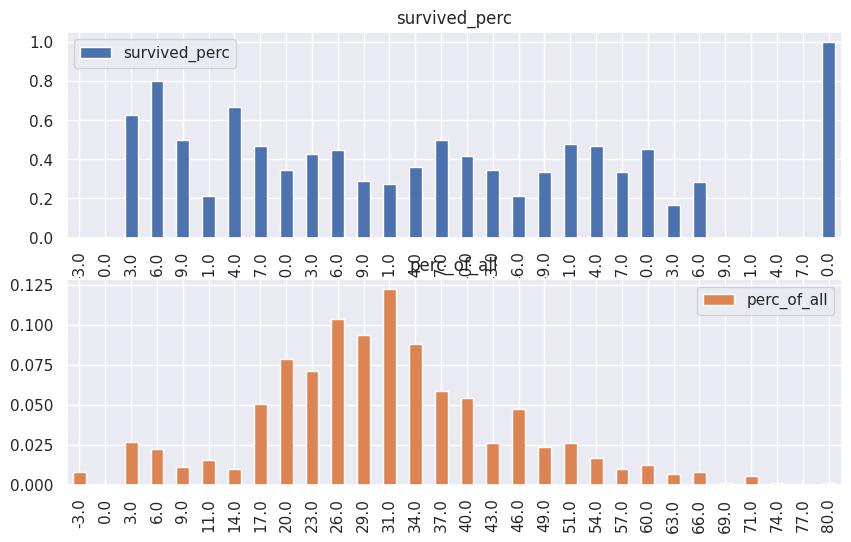

In [106]:
def continious_data_to_bins(column, bins_number):
    df_with_categorical_age, bins_arr = pd.cut(df_all[column], bins_number, retbins=True )
    groupby_age =  df_all.groupby(df_with_categorical_age)
    df_age = groupby_age['Survived'].agg(['mean', 'count'])
    df_age.set_index(np.round(bins_arr[1:]), inplace=True)
    df_age['count'] = df_age['count'] / df_all.shape[0]
    df_age.rename(columns={'mean': 'survived_perc',  'count': 'perc_of_all'}, inplace=True)
    return df_age

df_age = continious_data_to_bins('Age', 30)

df_for_plot = df_age
fig, axes = plt.subplots(2, dpi=100, figsize=(10, 6), sharex='')
df_age.plot.bar(ax=plt.gca(), subplots=True)


## Fooling around with deep learning

Epoch 1/10
3/3 [==============================] - 2s 187ms/step - loss: 0.3249 - accuracy: 0.6040 - val_loss: 0.2469 - val_accuracy: 0.6854
Epoch 2/10
3/3 [==============================] - 0s 77ms/step - loss: 0.2607 - accuracy: 0.6743 - val_loss: 0.5029 - val_accuracy: 0.4129
Epoch 3/10
3/3 [==============================] - 0s 55ms/step - loss: 0.3990 - accuracy: 0.5217 - val_loss: 0.2462 - val_accuracy: 0.6966
Epoch 4/10
3/3 [==============================] - 0s 74ms/step - loss: 0.2442 - accuracy: 0.6951 - val_loss: 0.3527 - val_accuracy: 0.5955
Epoch 5/10
3/3 [==============================] - 0s 81ms/step - loss: 0.3022 - accuracy: 0.6479 - val_loss: 0.2519 - val_accuracy: 0.6882
Epoch 6/10
3/3 [==============================] - 0s 62ms/step - loss: 0.2390 - accuracy: 0.6898 - val_loss: 0.3606 - val_accuracy: 0.5899

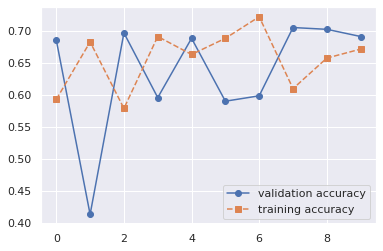

In [95]:
# my stupid and random try to deep learning without knowing anything
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


model = Sequential()
model.add(Dense(100, input_shape=(10, )))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error',
                  optimizer = 'nadam',
                  metrics = ['accuracy'])


titanic_recognition_model = model.fit(X_train, y_train,
              batch_size=128,
              epochs=10,
              validation_data=(X_test, y_test),
              shuffle=True)

plt.plot(titanic_recognition_model.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(titanic_recognition_model.history['accuracy'], '--s', label='training accuracy')
plt.legend();
